# ENCM 509 - Face Detection

In [1]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install lxml
!pip install cmake
!pip install "dlib-19.22.99-cp38-cp38-win_amd64.whl"
!pip install dlib


Processing c:\users\owner\desktop\encm-509-final-project\dlib-19.22.99-cp38-cp38-win_amd64.whl
dlib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


### Load Data
Dataset from : https://www.kaggle.com/datasets/trainingdatapro/face-detection-photos-and-labels/data

We've narrowed down the image dataset to 9 images, which cover a wide range of aspects that could interfere with face detection, such as hair, glasses, and lighting.


In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import dlib
import numpy as np


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

csv_path = "data/face_detection.csv"
df = pd.read_csv(csv_path)

# Read the image paths
image_paths = df["image"]
label_paths = df["label"]

full_paths = [os.path.join("data", img_path) for img_path in image_paths]
full_label_paths = [os.path.join("data", lbl_path) for lbl_path in label_paths]


In [3]:
import xml.etree.ElementTree as ET
import os

xml_file = "data/corrected.xml"

tree = ET.parse(xml_file)
root = tree.getroot()
# Extract just the filenames from full_paths
image_filenames = [os.path.basename(path) for path in full_paths]

truth_data = []
for image in root.findall("image"):
    img_name = image.get("name")
    
    # Check if the image name is in the list of filenames
    if os.path.basename(img_name) in image_filenames:
        width = int(image.get("width"))
        height = int(image.get("height"))
        
        for box in image.findall("box"):
            xtl = float(box.get("xtl"))
            ytl = float(box.get("ytl"))
            xbr = float(box.get("xbr"))
            ybr = float(box.get("ybr"))
            
            truth_data.append({
                "name": img_name,
                "bbox": (xtl, ytl, xbr, ybr),
                "width": width,
                "height": height
            })

# Print the filtered truth data
for img in truth_data:
    print(img)

{'name': 'images/1.jpg', 'bbox': (610.53, 1274.55, 1716.9, 2746.81), 'width': 2448, 'height': 3264}
{'name': 'images/3.jpg', 'bbox': (592.29, 766.1, 1232.29, 1756.5), 'width': 1936, 'height': 2592}
{'name': 'images/4.jpg', 'bbox': (284.7, 868.5, 1391.7, 2522.29), 'width': 1980, 'height': 2640}
{'name': 'images/9.jpg', 'bbox': (533.68, 455.8, 1682.12, 2024.4), 'width': 2448, 'height': 3264}
{'name': 'images/10.jpg', 'bbox': (707.24, 955.5, 1642.69, 2453.6), 'width': 2448, 'height': 3264}
{'name': 'images/12.jpg', 'bbox': (940.76, 785.4, 1980.36, 2306.17), 'width': 2448, 'height': 3264}
{'name': 'images/23.jpg', 'bbox': (1196.3, 1296.2, 2423.81, 3002.86), 'width': 3456, 'height': 4608}
{'name': 'images/28.jpg', 'bbox': (775.63, 459.9, 1858.44, 2134.2), 'width': 2448, 'height': 3264}
{'name': 'images/43.jpg', 'bbox': (855.38, 444.2, 1759.1, 1805.74), 'width': 2320, 'height': 3088}


In [4]:
# Load and convert images to grayscale
grayscale_images = []
for full_path in full_paths:
    image = cv2.imread(full_path)
    if image is None:
        print(f"Error loading image: {full_path}")
        continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    grayscale_images.append(gray)

### Helper Functions

IOU calculation code adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [5]:
def calculate_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [6]:
def display_images_in_grid(images, names, images_per_row=5):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    
    plt.figure(figsize=(15, num_rows * 3))
    for i, (img, name) in enumerate(zip(images, names)):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(name, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def calc_metrics_from_iou_threshold(thresholdValue, iouScores):
    TP = 0
    FP = 0

    for iou_list in iouScores:
        for iou in iou_list:
            if iou >= thresholdValue:
                TP += 1
            else:
                FP += 1
    
    return TP, FP, max(0, 9 - TP)


### Original Haar Cascades
Code adapted from https://www.datacamp.com/tutorial/face-detection-python-opencv#face-detection

In [8]:
def haar_cascades(images, truth_data, scaleFactor=1.1, minNeighbors=5):
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    
    results = []
    processed_images = []
    image_names = []
    
    for image, truth in zip(images, truth_data):
        if len(image.shape) == 2:
            image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image_copy = image.copy()
        
        detected_faces = face_classifier.detectMultiScale(image_copy, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        
        iou_list = []
        
        # Draw the original bounding box in green
        x1, y1, x2, y2 = map(int, truth['bbox'])
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 5)
        
        for (x, y, w, h) in detected_faces:
            detected_box = (x, y, x + w, y + h)
            iou = calculate_iou(detected_box, truth['bbox'])
            iou_list.append(iou)
            
            # Draw detected bounding box in red
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 5)
        
        results.append({
            "Image": truth['name'],
            "ScaleFactor": scaleFactor,
            "MinNeighbors": minNeighbors,
            "IoU": iou_list,
        })
        
        img_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        processed_images.append(img_rgb)
        image_names.append(truth['name'])
    
    return results, processed_images, image_names

           Image                                                      IoU
0   images/1.jpg                                     [0.7602199032046598]
1   images/3.jpg                      [0.0, 0.6549672922591074, 0.0, 0.0]
2   images/4.jpg                                     [0.6900237156190328]
3   images/9.jpg  [0.6952350518324195, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4  images/10.jpg                           [0.6432313648880684, 0.0, 0.0]
5  images/12.jpg                           [0.6994406810823207, 0.0, 0.0]
6  images/23.jpg                                     [0.6703852277190135]
7  images/28.jpg                                     [0.6684553831735386]
8  images/43.jpg                 [0.0, 0.6869927876067429, 0.0, 0.0, 0.0]


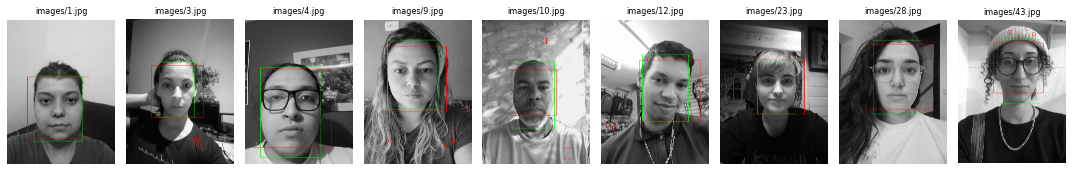

Scale Factor: 1.1, Min Neighbors: 4
True Positives: 9, False Positives: 18, False Negatives: 0
Precision: 0.3333, Recall: 1.0000


In [9]:
# Keeping scaleFactor=1.1
results_1, processed_images_1, image_names  = haar_cascades(grayscale_images, truth_data, scaleFactor=1.1, minNeighbors=4)

df_results_1 = pd.DataFrame(results_1)

print(df_results_1[['Image', 'IoU']])
display_images_in_grid(processed_images_1, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_1['IoU'])
print("Scale Factor: 1.1, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

           Image                        IoU
0   images/1.jpg       [0.7602199032046598]
1   images/3.jpg       [0.6549672922591074]
2   images/4.jpg       [0.6900237156190328]
3   images/9.jpg  [0.6952350518324195, 0.0]
4  images/10.jpg  [0.6432313648880684, 0.0]
5  images/12.jpg  [0.6994406810823207, 0.0]
6  images/23.jpg       [0.6703852277190135]
7  images/28.jpg       [0.6684553831735386]
8  images/43.jpg                      [0.0]


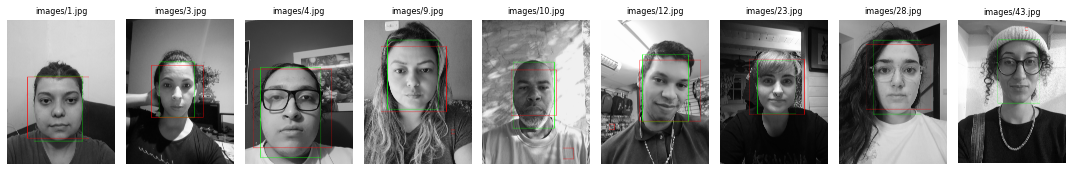

Scale Factor: 1.1, Min Neighbors: 10
True Positives: 8, False Positives: 4, False Negatives: 1
Precision: 0.6667, Recall: 0.8889


In [10]:
#Keeping scaleFactor=1.1
results_2, processed_images_2, image_names = haar_cascades(grayscale_images, truth_data, scaleFactor=1.1, minNeighbors=10)
df_results_2 = pd.DataFrame(results_2)

print(df_results_2[['Image', 'IoU']])
display_images_in_grid(processed_images_2, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_2['IoU'])
print("Scale Factor: 1.1, Min Neighbors: 10")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

           Image                   IoU
0   images/1.jpg  [0.7607821221321016]
1   images/3.jpg  [0.6603094786792205]
2   images/4.jpg                    []
3   images/9.jpg  [0.7382579775124012]
4  images/10.jpg  [0.6081752527409444]
5  images/12.jpg  [0.6994406810823207]
6  images/23.jpg  [0.4863031789813879]
7  images/28.jpg  [0.6722679354872927]
8  images/43.jpg                    []


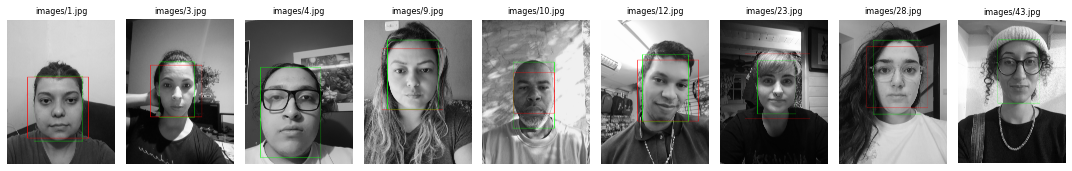

Scale Factor: 1.5, Min Neighbors: 4
True Positives: 6, False Positives: 1, False Negatives: 3
Precision: 0.8571, Recall: 0.6667


In [11]:
#Keeping minNeighbors=4
results_3, processed_images_3, image_names = haar_cascades(grayscale_images, truth_data, scaleFactor=1.5, minNeighbors=4)
df_results_3 = pd.DataFrame(results_3)

print(df_results_3[['Image', 'IoU']])
display_images_in_grid(processed_images_3, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_3['IoU'])
print("Scale Factor: 1.5, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

           Image                    IoU
0   images/1.jpg                     []
1   images/3.jpg   [0.6131720829329889]
2   images/4.jpg                     []
3   images/9.jpg             [0.0, 0.0]
4  images/10.jpg   [0.6346354162052144]
5  images/12.jpg                     []
6  images/23.jpg  [0.49484297408102546]
7  images/28.jpg                     []
8  images/43.jpg  [0.17216654114626645]


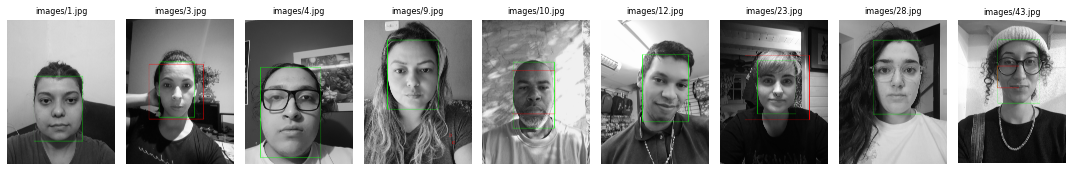

Scale Factor: 2.1, Min Neighbors: 4
True Positives: 2, False Positives: 4, False Negatives: 7
Precision: 0.3333, Recall: 0.2222


In [12]:
#Keeping minNeighbors=4
results_4, processed_images_4, image_names = haar_cascades(grayscale_images, truth_data, scaleFactor=2.1, minNeighbors=4)
df_results_4 = pd.DataFrame(results_4)

print(df_results_4[['Image', 'IoU']])
display_images_in_grid(processed_images_4, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_4['IoU'])
print("Scale Factor: 2.1, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Threshold: 0.25
TP: 8, FP: 4, FN: 1
Precision: 0.6667, Recall: 0.8889

Threshold: 0.5
TP: 8, FP: 4, FN: 1
Precision: 0.6667, Recall: 0.8889

Threshold: 0.75
TP: 1, FP: 11, FN: 8
Precision: 0.0833, Recall: 0.1111



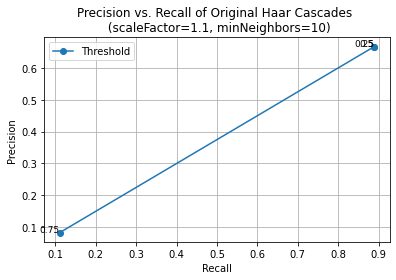

In [13]:
# Testing different thresholds for scaleFactor=1.1 and minNeighbors=10
thresholds_2 = [0.25, 0.50, 0.75]
precisions_2 = []
recalls_2 = []

for threshold_2 in thresholds_2:
    # Calculate TP, FP, FN at the different thresholds
    TP_2, FP_2, FN_2 = calc_metrics_from_iou_threshold(threshold_2, df_results_2['IoU'])
    
    # Calculate precision and recall
    precision_2 = TP_2 / (TP_2 + FP_2)
    recall_2 = TP_2 / (TP_2 + FN_2) 
    
    # Store the results
    precisions_2.append(precision_2)
    recalls_2.append(recall_2)

    print(f"Threshold: {threshold_2}")
    print(f"TP: {TP_2}, FP: {FP_2}, FN: {FN_2}")
    print(f"Precision: {precision_2:.4f}, Recall: {recall_2:.4f}\n")

# Plotting precision vs recall
plt.figure(figsize=(6, 4))
plt.plot(recalls_2, precisions_2, marker='o', label="Threshold")

# Annotate the graph with the threshold value
for i, t in enumerate(thresholds_2):
    plt.text(recalls_2[i], precisions_2[i], f"{t}", fontsize=9, ha='right')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall of Original Haar Cascades \n (scaleFactor=1.1, minNeighbors=10)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.95)
plt.show()


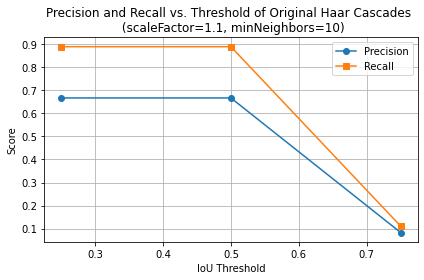

In [14]:
# List of IoU thresholds
thresholds_2 = [0.25, 0.50, 0.75]
precisions_2 = []
recalls_2 = []

for threshold_2 in thresholds_2:
    # Calculate TP, FP, FN at the current IoU threshold
    TP_2, FP_2, FN_2 = calc_metrics_from_iou_threshold(threshold_2, df_results_2['IoU'])
    
    # Calculate precision and recall
    precision_2 = TP_2 / (TP_2 + FP_2) 
    recall_2 = TP_2 / (TP_2 + FN_2)
    
    # Store the results
    precisions_2.append(precision_2)
    recalls_2.append(recall_2)

# Plotting precision and recall vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds_2, precisions_2, marker='o', label='Precision')
plt.plot(thresholds_2, recalls_2, marker='s', label='Recall')

plt.xlabel("IoU Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold of Original Haar Cascades \n (scaleFactor=1.1, minNeighbors=10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LBP-based Haar Cascades
Code adapted from https://www.datacamp.com/tutorial/face-detection-python-opencv#face-detection

In [15]:
def lbp_haar_cascades(images, truth_data, scaleFactor=1.1, minNeighbors=5):
    face_classifier = cv2.CascadeClassifier('lbpcascade_frontalface_improved.xml')
    
    results = []
    processed_images = []
    image_names = []
    
    for image, truth in zip(images, truth_data):
        if len(image.shape) == 2:
            image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image_copy = image.copy()
        
        detected_faces = face_classifier.detectMultiScale(
            image_copy, 
            scaleFactor=scaleFactor, 
            minNeighbors=minNeighbors
        )
        
        iou_list = []
        
        # Draw the original bounding box in green
        x1, y1, x2, y2 = map(int, truth['bbox'])
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 5)
        
        for (x, y, w, h) in detected_faces:
            detected_box = (x, y, x + w, y + h)
            iou = calculate_iou(detected_box, truth['bbox'])
            iou_list.append(iou)
            
            # Draw detected bounding box in red
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 5)
        
        results.append({
            "Image": truth['name'],
            "ScaleFactor": scaleFactor,
            "MinNeighbors": minNeighbors,
            "IoU": iou_list,
        })
        
        img_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        processed_images.append(img_rgb)
        image_names.append(truth['name'])
    
    return results, processed_images, image_names

           Image                                         IoU
0   images/1.jpg                        [0.5838852225946642]
1   images/3.jpg                        [0.5589662359946083]
2   images/4.jpg                        [0.6396969279620873]
3   images/9.jpg                       [0.48871524673841965]
4  images/10.jpg                       [0.37960377450953103]
5  images/12.jpg  [0.3543882931728564, 0.028957419255831153]
6  images/23.jpg                        [0.5684145353855067]
7  images/28.jpg                        [0.5343511134646556]
8  images/43.jpg                                          []


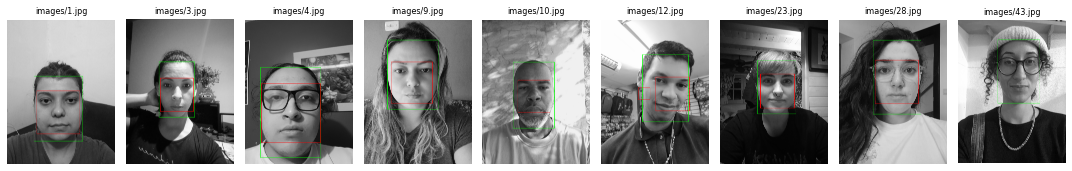

Scale Factor: 1.1, Min Neighbors: 4
True Positives: 5, False Positives: 4, False Negatives: 4
Precision: 0.5556, Recall: 0.5556


In [16]:
#Keeping scaleFactor=1.1
results_5, processed_images_5, image_names  = lbp_haar_cascades(grayscale_images, truth_data, scaleFactor=1.1, minNeighbors=4)

df_results_5 = pd.DataFrame(results_5)

print(df_results_5[['Image', 'IoU']])
display_images_in_grid(processed_images_5, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_5['IoU'])
print("Scale Factor: 1.1, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

           Image                    IoU
0   images/1.jpg   [0.5838852225946642]
1   images/3.jpg   [0.5589662359946083]
2   images/4.jpg   [0.6396969279620873]
3   images/9.jpg  [0.48871524673841965]
4  images/10.jpg  [0.37960377450953103]
5  images/12.jpg                     []
6  images/23.jpg   [0.5684145353855067]
7  images/28.jpg   [0.5343511134646556]
8  images/43.jpg                     []


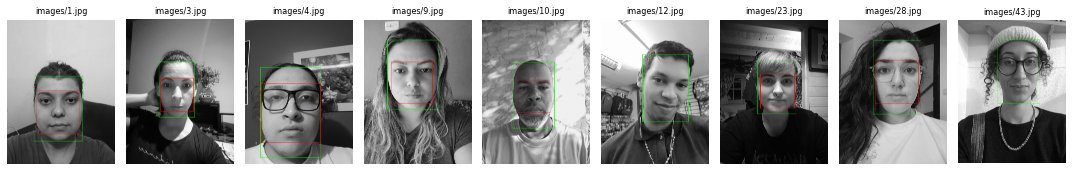

Scale Factor: 1.1, Min Neighbors: 10
True Positives: 5, False Positives: 2, False Negatives: 4
Precision: 0.7143, Recall: 0.5556


In [17]:
#Keeping scaleFactor=1.1
results_6, processed_images_6, image_names  = lbp_haar_cascades(grayscale_images, truth_data, scaleFactor=1.1, minNeighbors=10)

df_results_6 = pd.DataFrame(results_6)

print(df_results_6[['Image', 'IoU']])
display_images_in_grid(processed_images_6, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_6['IoU'])
print("Scale Factor: 1.1, Min Neighbors: 10")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

           Image                    IoU
0   images/1.jpg    [0.758285850388089]
1   images/3.jpg  [0.41573758976181113]
2   images/4.jpg   [0.6777472081234848]
3   images/9.jpg                     []
4  images/10.jpg                     []
5  images/12.jpg                     []
6  images/23.jpg   [0.6347921039171375]
7  images/28.jpg   [0.6594151329249155]
8  images/43.jpg                     []


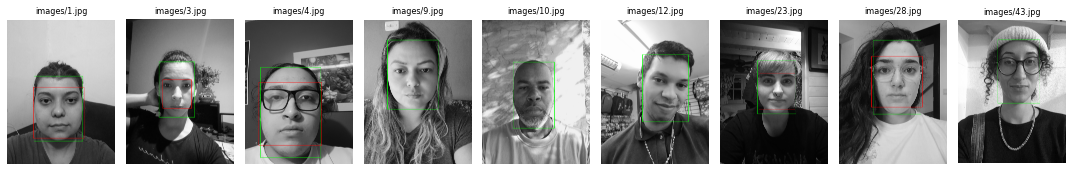

Scale Factor: 1.5, Min Neighbors: 4
True Positives: 4, False Positives: 1, False Negatives: 5
Precision: 0.8000, Recall: 0.4444


In [18]:
#Keeping minNeighbors=4
results_7, processed_images_7, image_names  = lbp_haar_cascades(grayscale_images, truth_data, scaleFactor=1.5, minNeighbors=4)

df_results_7 = pd.DataFrame(results_7)

print(df_results_7[['Image', 'IoU']])
display_images_in_grid(processed_images_7, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_7['IoU'])
print("Scale Factor: 1.5, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

           Image                    IoU
0   images/1.jpg  [0.47036615091478584]
1   images/3.jpg                     []
2   images/4.jpg                     []
3   images/9.jpg    [0.425336757524366]
4  images/10.jpg                     []
5  images/12.jpg                     []
6  images/23.jpg    [0.365786868623278]
7  images/28.jpg   [0.4226320905419398]
8  images/43.jpg                     []


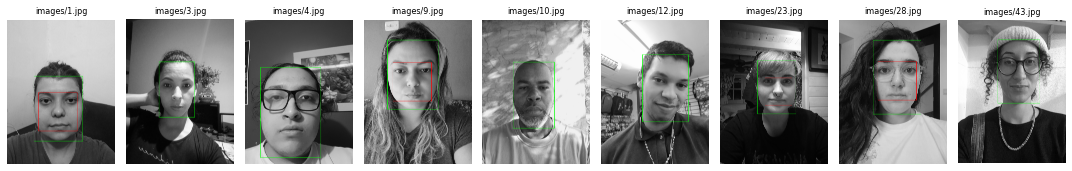

Scale Factor: 2.1, Min Neighbors: 4
True Positives: 0, False Positives: 4, False Negatives: 9
Precision: 0.0000, Recall: 0.0000


In [19]:
#Keeping minNeighbors=4
results_8, processed_images_8, image_names  = lbp_haar_cascades(grayscale_images, truth_data, scaleFactor=2.1, minNeighbors=4)

df_results_8 = pd.DataFrame(results_8)

print(df_results_8[['Image', 'IoU']])
display_images_in_grid(processed_images_8, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_8['IoU'])
print("Scale Factor: 2.1, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Threshold: 0.25
TP: 5, FP: 0, FN: 4
Precision: 1.0000, Recall: 0.5556

Threshold: 0.5
TP: 4, FP: 1, FN: 5
Precision: 0.8000, Recall: 0.4444

Threshold: 0.75
TP: 1, FP: 4, FN: 8
Precision: 0.2000, Recall: 0.1111



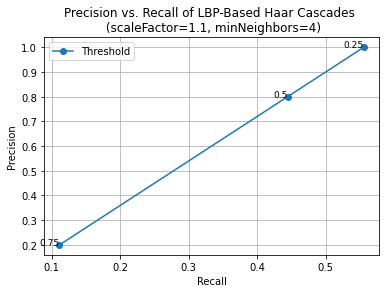

In [27]:
# Testing different thresholds for scaleFactor=1.5 and minNeighbors=4

# List of IoU thresholds
thresholds_7 = [0.25, 0.50, 0.75] 
precisions_7 = []
recalls_7 = []

for threshold_7 in thresholds_7:
    # Calculate TP, FP, FN at the current IoU threshold
    TP_7, FP_7, FN_7 = calc_metrics_from_iou_threshold(threshold_7, df_results_7['IoU'])
    
    # Calculate precision and recall
    precision_7 = TP_7 / (TP_7 + FP_7) 
    recall_7 = TP_7 / (TP_7 + FN_7) 
    
    # Store the results
    precisions_7.append(precision_7)
    recalls_7.append(recall_7)

    print(f"Threshold: {threshold_7}")
    print(f"TP: {TP_7}, FP: {FP_7}, FN: {FN_7}")
    print(f"Precision: {precision_7:.4f}, Recall: {recall_7:.4f}\n")

# Plotting Precision vs. Recall
plt.figure(figsize=(6, 4))
plt.plot(recalls_7, precisions_7, marker='o', label="Threshold")

# Annotate the graph with the threshold value
for i, t in enumerate(thresholds_7):
    plt.text(recalls_7[i], precisions_7[i], f"{t}", fontsize=9, ha='right')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall of LBP-Based Haar Cascades \n (scaleFactor=1.1, minNeighbors=4)")
plt.grid(True)
plt.legend()
plt.show()


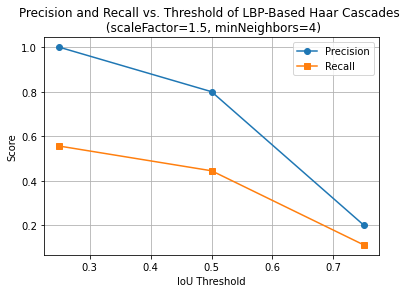

In [29]:
# List of IoU thresholds
thresholds_7 = [0.25, 0.50, 0.75]
precisions_7 = []
recalls_7 = []

for threshold_7 in thresholds_7:
    # Calculate TP, FP, FN at the current IoU threshold
    TP_7, FP_7, FN_7 = calc_metrics_from_iou_threshold(threshold_7, df_results_7['IoU'])
    
    # Calculate precision and recall
    precision_7 = TP_7 / (TP_7 + FP_7)
    recall_7 = TP_7 / (TP_7 + FN_7) 
    
    # Store the results
    precisions_7.append(precision_7)
    recalls_7.append(recall_7)

# Plotting precision and recall vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds_7, precisions_7, marker='o', label='Precision')
plt.plot(thresholds_7, recalls_7, marker='s', label='Recall')

plt.xlabel("IoU Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold of LBP-Based Haar Cascades \n (scaleFactor=1.5, minNeighbors=4)")
plt.legend()
plt.grid(True)
plt.show()


### HOG + SVM

code adapted from https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [22]:
def hog_svm_faces(images, truth_data):
    import dlib
    import cv2

    # Initialize dlib's HOG + SVM face detector algorithm
    face_detector = dlib.get_frontal_face_detector()

    results = []
    processed_images = []
    image_names = []
    all_iou_scores = []

    for image, truth in zip(images, truth_data):
        # Loop through the images and copy the greyscale images then convert to BGR
        gray = image.copy()
        image_copy = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        # Run face detection algorithm
        detections = face_detector(gray)
        iou_list = []

        # Draw the ground truth bounding box in green
        x1, y1, x2, y2 = map(int, truth['bbox'])
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 4)

        for det in detections:
            dx1, dy1, dx2, dy2 = det.left(), det.top(), det.right(), det.bottom()
            pred_box = (dx1, dy1, dx2, dy2)
            
            # Calculate IoU around the predicted box and ground truth
            iou = calculate_iou(pred_box, truth['bbox'])
            iou_list.append(iou)
            
            # Draw the predicted box in red
            cv2.rectangle(image_copy, (dx1, dy1), (dx2, dy2), (0, 0, 255), 4)

        results.append({
            "Image": truth['name'],
            "Detected Faces": len(detections),
            "IoU": iou_list
        })
        
        # Store the results of the algorithm
        all_iou_scores.append(iou_list)
        img_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        processed_images.append(img_rgb)
        image_names.append(truth['name'])

    return results, processed_images, image_names, all_iou_scores


           Image  Detected Faces                   IoU
0   images/1.jpg               1   [0.729578490064711]
1   images/3.jpg               1  [0.6381988407003961]
2   images/4.jpg               1    [0.69228063487315]
3   images/9.jpg               1  [0.5996156129048329]
4  images/10.jpg               1  [0.6004074564409028]
5  images/12.jpg               1  [0.6724994856825907]
6  images/23.jpg               1  [0.7319212064689716]
7  images/28.jpg               1  [0.6726168888916795]
8  images/43.jpg               0                    []


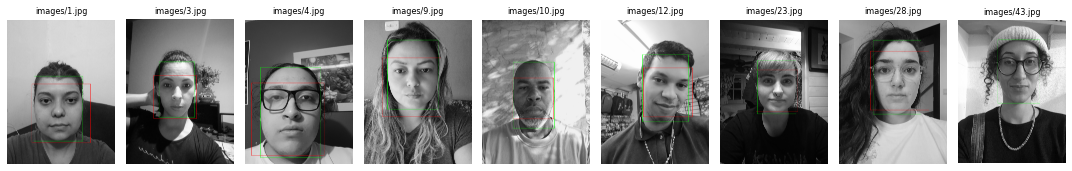

True Positives: 8, False Positives: 0, False Negatives: 1
Precision: 1.0000, Recall: 0.8889


In [23]:
results, processed_images, image_names, iou_scores = hog_svm_faces(grayscale_images, truth_data)
# Add the results to a pandas DataFrame
df_results_hogsvm = pd.DataFrame(results)
print(df_results_hogsvm[['Image', 'Detected Faces', 'IoU']])

# Display all 9 images in a grid
display_images_in_grid(processed_images, image_names, images_per_row=9)

# Evaluate the performance at IoU threshold = 0.25
TP, FP, FN = calc_metrics_from_iou_threshold(0.25, df_results_hogsvm['IoU'])
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# Calculate precision and recall
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Threshold: 0.25
TP: 8, FP: 0, FN: 1
Precision: 1.0000, Recall: 0.8889

Threshold: 0.5
TP: 8, FP: 0, FN: 1
Precision: 1.0000, Recall: 0.8889

Threshold: 0.75
TP: 0, FP: 8, FN: 9
Precision: 0.0000, Recall: 0.0000



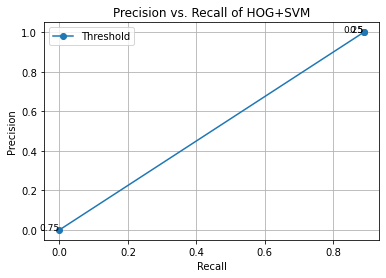

In [30]:
# Testing different thresholds
thresholds_hogsvm = [0.25, 0.50, 0.75]
precisions_hogsvm = []
recalls_hogsvm = []

for threshold_hogsvm in thresholds_hogsvm:
    # Calculate TP, FP, FN at the different thresholds
    TP_hogsvm, FP_hogsvm, FN_hogsvm = calc_metrics_from_iou_threshold(threshold_hogsvm, df_results_hogsvm['IoU'])
    
    # Calculate precision and recall
    precision_hogsvm = TP_hogsvm / (TP_hogsvm + FP_hogsvm) 
    recall_hogsvm = TP_hogsvm / (TP_hogsvm + FN_hogsvm) 
    
    # Store the results
    precisions_hogsvm.append(precision_hogsvm)
    recalls_hogsvm.append(recall_hogsvm)

    print(f"Threshold: {threshold_hogsvm}")
    print(f"TP: {TP_hogsvm}, FP: {FP_hogsvm}, FN: {FN_hogsvm}")
    print(f"Precision: {precision_hogsvm:.4f}, Recall: {recall_hogsvm:.4f}\n")

# Plotting precision vs recall
plt.figure(figsize=(6, 4))
plt.plot(recalls_hogsvm, precisions_hogsvm, marker='o', label="Threshold")

# Annotate the graph with the threshold value
for i, t in enumerate(thresholds_hogsvm):
    plt.text(recalls_hogsvm[i], precisions_hogsvm[i], f"{t}", fontsize=9, ha='right')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall of HOG+SVM")
plt.grid(True)
plt.legend()
plt.show()

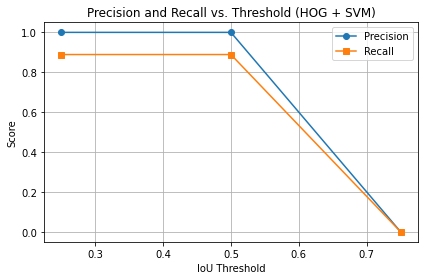

In [31]:
# List of IoU thresholds
thresholds_hogsvm = [0.25, 0.50, 0.75]
precisions_hogsvm = []
recalls_hogsvm = []

for threshold_hogsvm in thresholds_hogsvm:
    # Calculate TP, FP, FN at the current IoU threshold
    TP_hogsvm, FP_hogsvm, FN_hogsvm = calc_metrics_from_iou_threshold(threshold_hogsvm, df_results_hogsvm['IoU'])
    
    # Calculate precision and recall
    precision_hogsvm = TP_hogsvm / (TP_hogsvm + FP_hogsvm) 
    recall_hogsvm = TP_hogsvm / (TP_hogsvm + FN_hogsvm)
    
    # Store the results
    precisions_hogsvm.append(precision_hogsvm)
    recalls_hogsvm.append(recall_hogsvm)

# Plotting precision and recall vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds_hogsvm, precisions_hogsvm, marker='o', label='Precision')
plt.plot(thresholds_hogsvm, recalls_hogsvm, marker='s', label='Recall')

plt.xlabel("IoU Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold (HOG + SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
